
✅ Movie Type Output:
        Movie_Type  count
0            Drama  34007
1           Comedy  16349
2           Action  10234
3          Romance   9094
4           Horror   8798
5         Thriller   8744
6  Science Fiction   8141
7        Adventure   7155
8          Mystery   6948
9        Animation   6897

✅ Actor Count Output:


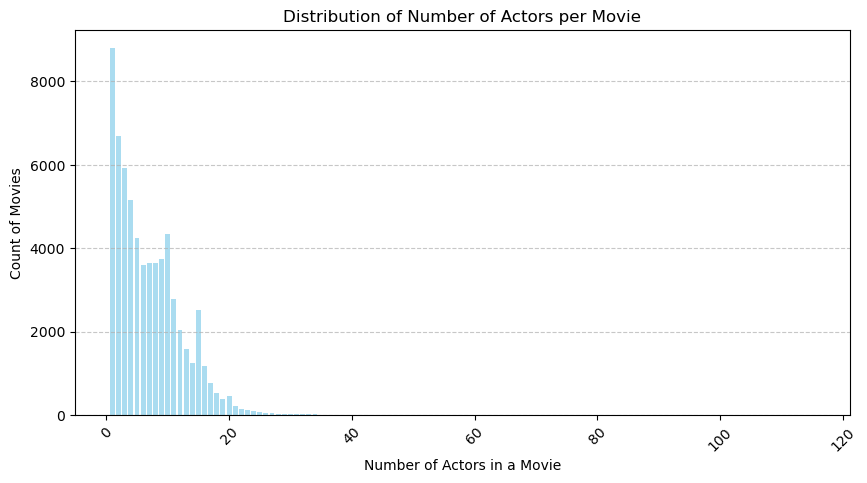

    Number of Actors  Movie Count
0                  1         8792
1                  2         6696
2                  3         5924
3                  4         5154
5                  5         4254
..               ...          ...
60                72            1
62                78            1
59                81            1
63                87            1
66               115            1

[67 rows x 2 columns]

✅ Actor Distribution for Male:


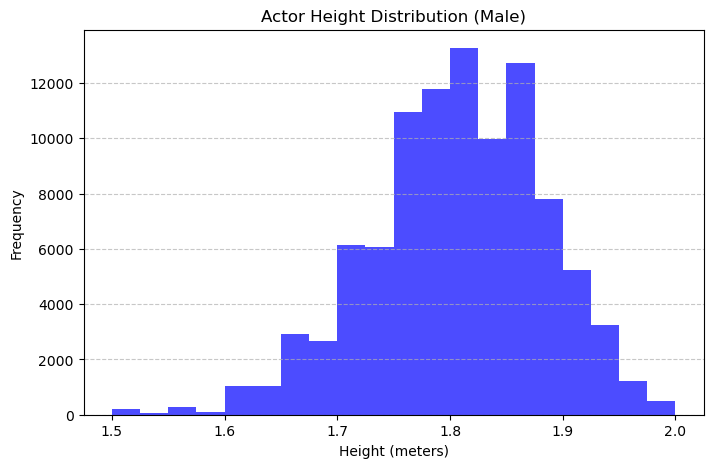


✅ Actor Distribution for Female:


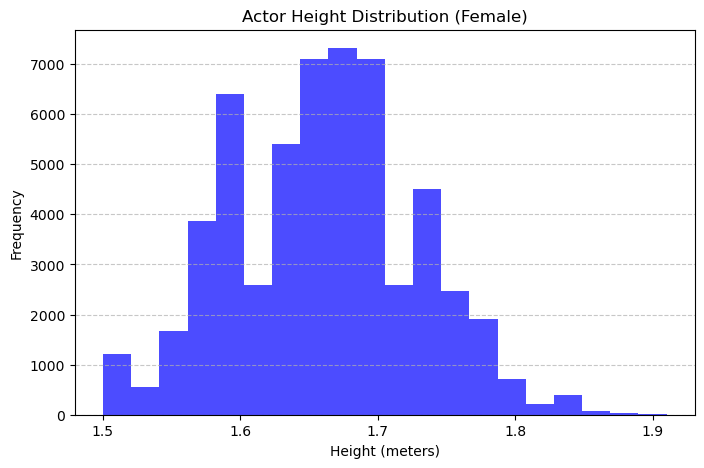

In [2]:
import os
import pandas as pd
import ast  # For safely parsing genre strings
import matplotlib.pyplot as plt


class MovieAnalyzer:
    DATA_DIR = "downloads"
    MOVIE_FILE = "movie.metadata.tsv"
    CHARACTER_FILE = "character.metadata.tsv"

    # Freebase genre ID to readable name mapping
    GENRE_MAPPING = {
        "/m/07s9rl0": "Drama",
        "/m/01z4y": "Comedy",
        "/m/02l7c8": "Action",
        "/m/01g6gs": "Romance",
        "/m/02kdv5l": "Horror",
        "/m/01jfsb": "Thriller",
        "/m/02hmvc": "Science Fiction",
        "/m/03q4nz": "Adventure",
        "/m/0lsxr": "Mystery",
        "/m/0219x_": "Animation",
    }

    def __init__(self):
        """Loads the movie and character datasets and merges them."""
        self.movies_df = self._load_movies()
        self.characters_df = self._load_characters()
        self.merged_df = self._merge_data()
        self._clean_data()

    def _load_movies(self):
        """Loads movie metadata into a pandas DataFrame."""
        file_path = os.path.join(self.MOVIE_FILE)
        columns = [
            "wikipedia_movie_id", "freebase_movie_id", "movie_name",
            "release_date", "box_office", "runtime", "languages",
            "countries", "genres",
        ]
        return pd.read_csv(file_path, sep="\t", header=None, names=columns)

    def _load_characters(self):
        """Loads character metadata into a pandas DataFrame."""
        file_path = os.path.join(self.CHARACTER_FILE)
        columns = [
            "wikipedia_movie_id", "freebase_movie_id", "release_date",
            "character_name", "actor_dob", "actor_gender", "actor_height",
            "actor_ethnicity", "actor_name", "actor_age_at_release",
            "character_actor_map_id", "character_id", "actor_id",
        ]
        return pd.read_csv(file_path, sep="\t", header=None, names=columns)

    def _merge_data(self):
        """Merges movie and character datasets on 'wikipedia_movie_id'."""
        return pd.merge(
            self.characters_df, self.movies_df, on="wikipedia_movie_id", how="inner"
        )

    def _clean_data(self):
        """Cleans and preprocesses the merged dataset."""
        self.merged_df["actor_gender"] = self.merged_df["actor_gender"].replace(
            {"M": "Male", "F": "Female"}
        )

        drop_columns = ["release_date_x", "freebase_movie_id_x",
                        "freebase_movie_id_y"]
        self.merged_df.drop(
            columns=[col for col in drop_columns if col in self.merged_df.columns],
            inplace=True,
        )

    def movie_type(self, N=10):
        """Returns the top N most common movie genres."""
        if not isinstance(N, int):
            raise ValueError("N must be an integer")

        def safe_parse(genre_str):
            try:
                return (
                    ast.literal_eval(genre_str)
                    if isinstance(genre_str, str) and genre_str.startswith("{")
                    else []
                )
            except (SyntaxError, ValueError) as e:
                print(f"Error parsing genre string: {e}")
                return []

        self.movies_df["genres"] = self.movies_df["genres"].apply(safe_parse)

        genre_counts = pd.Series(
            [
                self.GENRE_MAPPING.get(genre, genre)
                for sublist in self.movies_df["genres"]
                for genre in sublist
            ]
        ).value_counts()

        return genre_counts.head(N).reset_index().rename(
            columns={"index": "Movie_Type", 0: "Count"}
        )

    def actor_count(self, plot=False):
        """Returns a histogram of the number of actors per movie."""
        valid_actors = self.merged_df.dropna(subset=["actor_name"])
        actor_counts = (
            valid_actors.groupby("wikipedia_movie_id")["actor_name"]
            .count()
            .value_counts()
            .reset_index()
        )
        actor_counts.columns = ["Number of Actors", "Movie Count"]

        actor_counts = actor_counts.sort_values(by="Number of Actors", ascending=True)

        if plot:
            plt.figure(figsize=(10, 5))
            plt.bar(
                actor_counts["Number of Actors"],
                actor_counts["Movie Count"],
                color="skyblue",
                alpha=0.7,
            )
            plt.xlabel("Number of Actors in a Movie")
            plt.ylabel("Count of Movies")
            plt.title("Distribution of Number of Actors per Movie")
            plt.xticks(rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()

        return actor_counts

    def actor_distributions(
        self, gender="All", min_height=0.5, max_height=2.5, plot=False
    ):
        """Returns filtered actors by height and gender, with an optional plot."""
        if not isinstance(gender, str) or not isinstance(
            min_height, (int, float)
        ) or not isinstance(max_height, (int, float)):
            raise ValueError("Invalid data type for arguments")

        self.merged_df["actor_height"] = pd.to_numeric(
            self.merged_df["actor_height"], errors="coerce"
        )

        filtered_df = self.merged_df.dropna(subset=["actor_height"])
        filtered_df = filtered_df[
            (filtered_df["actor_height"] >= min_height)
            & (filtered_df["actor_height"] <= max_height)
        ]

        if gender != "All":
            valid_genders = filtered_df["actor_gender"].dropna().unique()
            if gender not in valid_genders:
                raise ValueError(
                    f"Invalid gender. Choose from: {list(valid_genders) + ['All']}"
                )
            filtered_df = filtered_df[filtered_df["actor_gender"] == gender]

        if filtered_df.empty:
            print(
                f"⚠️ No actors found for Gender={gender}, "
                f"Height {min_height}m - {max_height}m."
            )
            return pd.DataFrame()

        if plot:
            plt.figure(figsize=(8, 5))
            plt.hist(filtered_df["actor_height"], bins=20, color="blue", alpha=0.7)
            plt.xlabel("Height (meters)")
            plt.ylabel("Frequency")
            plt.title(f"Actor Height Distribution ({gender})")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()

        return filtered_df


# Initialize and test the class
if __name__ == "__main__":
    analyzer = MovieAnalyzer()

    print("\n✅ Movie Type Output:")
    print(analyzer.movie_type(10))

    print("\n✅ Actor Count Output:")
    print(analyzer.actor_count(plot=True))

    print("\n✅ Actor Distribution for Male:")
    analyzer.actor_distributions(
        gender="Male", min_height=1.5, max_height=2.0, plot=True
    )

    print("\n✅ Actor Distribution for Female:")
    analyzer.actor_distributions(
        gender="Female", min_height=1.5, max_height=2.0, plot=True
    )
